In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import product

In [2]:
xs = np.random.uniform(low=0.0, high=1000.0, size=2500)
ys = np.random.uniform(low=0.0, high=1000.0, size=2500)

'''f1 = lambda x : 50000 / x
df1 = pd.DataFrame({'x' : xs, 'y' : ys})
df1['class'] = np.where(df1['y'] > f1(df1['x']), 1, 0)'''

f3 = lambda x : np.power(x - 750, 2) + 250
df3 = pd.DataFrame({'x' : xs, 'y' : ys})
df3['class'] = np.where(df3['y'] > f3(df3['x']), 1, 0)

'''X = df1[['x', 'y']].to_numpy()
y = df1[['class']].to_numpy()'''

X = df3[['x', 'y']].to_numpy()
y = df3[['class']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Greedy hill climb (GHC)

In [3]:
def GHC(model, point, step_size, n_dim):
    
    while True:
        
        # Calculate class probabilities for the point
        point_prob = model.predict_proba(point)
        
        # If we have not yet encountered both classes
        if point_prob.size < 2:
            return point
        
        # Calculate uncertainty for current point
        current_min = np.abs(np.amin(np.diff(point_prob)))
        
        # Generate an increment in every direction
        increments = np.array(list(product([-step_size, 0, step_size], repeat=1*n_dim)))
        
        # Generate steps from increments
        steps = point + increments
        
        # Calculate probabilities for each step
        probs = model.predict_proba(steps)
        
        # Calculate difference between class 0 and class 1 probabilities
        diffs = np.abs(np.diff(probs))
        
        # Get the step with the smallest difference in class probabilities (i.e. most uncertain)
        new_min = np.amin(diffs)
        
        if new_min < current_min:
            point = steps[np.argmin(diffs)].reshape(1, n_dim)
        else:
            return point

# Query synthesis with GHC

In [4]:
def oracle(x1, x2):
    return 1 if x2 > f3(x1) else 0

In [5]:
def QS_GHC(model, ranges, step_size, n_iterations):
    
    scores = []
    
    X = np.empty((0,2), float)
    y = np.empty((0,1), float)
    
    n_dim = len(ranges)
    
    first = True
    
    for i in range(n_iterations):
        
        point = np.random.randint(low=0,high=ranges).reshape(1, n_dim)
        
        if first:
            query = point
            first = False
        else:
            query = GHC(model, point, step_size, n_dim)
            
        
        # get response from oracle
        label = np.array([[oracle(query[0][0], query[0][1])]])
        
        # Update dataset
        X = np.append(X, query, axis=0)
        y = np.append(y, label, axis=0)
 
        # Refit model
        model.fit(X,y.ravel())
        
        accuracy = model.score(X_test, y_test)
        
        scores.append(accuracy)
    
    return scores
        

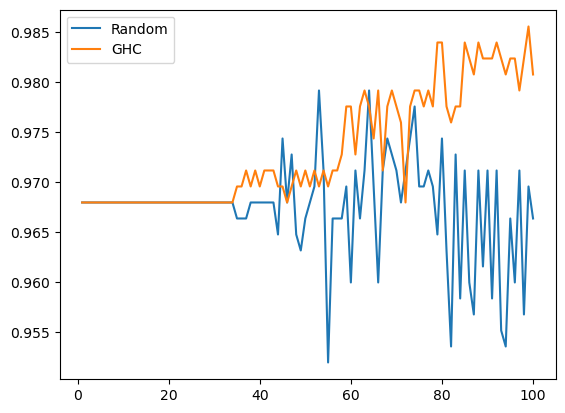

In [6]:
clf1 = RandomForestClassifier()
random_scores = QS_GHC(clf1, [1000,1000], 0, 100)

clf2 = RandomForestClassifier()
qhs_scores = QS_GHC(clf2, [1000,1000], 5, 100)
x_axis = np.arange(1,101)
plt.plot(x_axis,random_scores, label='Random')
plt.plot(x_axis,qhs_scores, label='GHC')
plt.legend()
plt.show()